In [1]:
import sys

print(sys.version) 

3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0 (clang-1500.1.0.2.5)]


In [2]:
# Import libraries
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

## Off-the-shelf Model Exploration

In [3]:
# Load the dataset and display them 
dev_df = pd.read_csv('civility_data/dev.tsv', sep='\t')
mini_demographic_dev_df = pd.read_csv('civility_data/mini_demographic_dev.tsv', sep='\t')
dev_df.head()

,text,label,category,perspective_score
0,@USER She should ask a few native Americans wh...,OFF,UNT,0.311852
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,0.566334
2,Amazon is investigating Chinese employees who ...,NOT,NaN,0.110361
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,0.927032
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,0.319764


In [4]:
mini_demographic_dev_df.head()

,text,demographic,perspective_score
0,People make mistakes. It takes a good person t...,White,0.041031
1,"Only one on our road with power, but no cable ...",White,0.061435
2,I love when baby's yawn I think it's so cute.,White,0.056817
3,theres so many hoes now that i actually think ...,White,0.503459
4,Today is the day Adalynn Alexis will be here! ...,White,0.092183


In [32]:
# Set a threshold for perspective score as classifier
threshold = 0.8

# apply the threshold and create a new column predicted_label 
dev_df['predicted_label'] = dev_df['perspective_score'].apply(lambda x: 'OFF' if x > threshold else 'NOT')
# display it 
dev_df.head()

,text,label,category,perspective_score,predicted_label
0,@USER She should ask a few native Americans wh...,OFF,UNT,0.311852,NOT
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,0.566334,OFF
2,Amazon is investigating Chinese employees who ...,NOT,NaN,0.110361,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,0.927032,OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,0.319764,NOT


In [33]:
# Then we are going to calculate the accuracy and other metrics for dev dataset
accuracy = accuracy_score(dev_df['label'], dev_df['predicted_label'])
precision, recall, f1, _ = precision_recall_fscore_support(dev_df['label'], dev_df['predicted_label'], average=None, labels=['OFF', 'NOT'])
macro_f1 = precision_recall_fscore_support(dev_df['label'], dev_df['predicted_label'], average='macro', labels=['OFF', 'NOT'])[2]
# Display the results
print("Accuracy:", accuracy)
print("Precision (OFF, NOT):", precision)
print("Recall (OFF, NOT):", recall)
print("F1 Score (OFF, NOT):", f1)
print("Macro F1 Score (OFF, NOT):", macro_f1)

Accuracy: 0.804380664652568
Precision (OFF, NOT): [0.69803063 0.86043829]
Recall (OFF, NOT): [0.725     0.8438914]
F1 Score (OFF, NOT): [0.71125975 0.85208452]
Macro F1 Score (OFF, NOT): 0.7816721389338279


In [7]:
# Now move to the mini_demographic_dev dataset, 
# and since all data contains no toxic tweets, we can add another column as true_label
mini_demographic_dev_df['true_label'] = 'NOT'

# then use the threshold to get predicted label 
mini_demographic_dev_df['predicted_label'] = mini_demographic_dev_df['perspective_score'].apply(lambda x: 'OFF' if x > threshold else 'NOT')
# display it
mini_demographic_dev_df.head()

,text,demographic,perspective_score,true_label,predicted_label
0,People make mistakes. It takes a good person t...,White,0.041031,NOT,NOT
1,"Only one on our road with power, but no cable ...",White,0.061435,NOT,NOT
2,I love when baby's yawn I think it's so cute.,White,0.056817,NOT,NOT
3,theres so many hoes now that i actually think ...,White,0.503459,NOT,NOT
4,Today is the day Adalynn Alexis will be here! ...,White,0.092183,NOT,NOT


In [8]:
# Then lets calculate its FPR for each demographic group
# A dictionary with demographic as key, and their FPR as value
fpr_demographics = {}
for demographic in mini_demographic_dev_df['demographic'].unique():
    # Subset by demographic group
    demo_data = mini_demographic_dev_df[mini_demographic_dev_df['demographic'] == demographic]
    # Calculate false positives (predicted 'OFF' when true label is 'NOT')
    false_positives = sum(demo_data['predicted_label'] == 'OFF')
    total = len(demo_data)
    fpr_demographics[demographic] = false_positives / total if total > 0 else 0

# Display the FPR results for each demographic
fpr_demographics


{'White': 0.07319952774498228,
 'Hispanic': 0.10149253731343283,
 'AA': 0.1897590361445783,
 'Other': 0.011764705882352941}

## Custom Model Exploration

In [9]:
# Load the training data
train_df = pd.read_csv('./civility_data/train.tsv', sep='\t')
train_df.head()

,text,label,category
0,@USER @USER You are an embarrassing citizen!!,OFF,TIN
1,@USER Seems hard to believe that you stood nex...,OFF,TIN
2,@USER @USER @USER Wow !!! no wonder the Libera...,OFF,TIN
3,@USER @USER And not all idiots grandstands lik...,OFF,TIN
4,@USER Bring on the hypocrite gungrabber. MAGA,OFF,TIN


In [10]:
# Import necessary packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


In [11]:
# Extract the text data and labels for training and dev sets
X_train_texts = train_df['text']
y_train_labels = train_df['label']

X_dev_texts = dev_df['text']
y_dev_labels = dev_df['label']

In [12]:
# Initialize the TF-IDF Vectorizer to convert text into numerical data with n-grams (unigrams and bigrams)
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=7000,
    min_df=5, # terms that appear in fewer than 5 documents are ignored.
    max_df=0.7, # terms appearing in more than 70% of documents are ignored
    sublinear_tf=True
)
# Fit the vectorizer on the training text and transform both training and dev texts
X_train = vectorizer.fit_transform(X_train_texts)
X_dev = vectorizer.transform(X_dev_texts)

# Initialize the logistic regression model and train it on the vectorized training data
# model = LogisticRegression(max_iter=1000)
model = LogisticRegression(
    max_iter=10000,
    C=0.7,
    class_weight='balanced',
    solver='saga', # improve performance by enforcing sparsity in the coefficients, potentially eliminating uninformative features
    penalty='l1', # improve interpretability by zeroing out less important features
    random_state=42
)
model.fit(X_train, y_train_labels)


y_dev_pred = model.predict(X_dev)

In [13]:
# Calculate accuracy
accuracy = accuracy_score(y_dev_labels, y_dev_pred)

# Calculate precision, recall, and F1 score for both classes (OFF and NOT)
precision, recall, f1, _ = precision_recall_fscore_support(y_dev_labels, y_dev_pred, labels=['OFF', 'NOT'])
macro_f1 = precision_recall_fscore_support(y_dev_labels, y_dev_pred, labels=['OFF', 'NOT'], average='macro')[2]

# Display the performance metrics for both classes
performance_metrics = {
    "Accuracy": accuracy,
    "Precision (OFF)": precision[0],
    "Precision (NOT)": precision[1],
    "Recall (OFF)": recall[0],
    "Recall (NOT)": recall[1],
    "F1 Score (OFF)": f1[0],
    "F1 Score (NOT)": f1[1],
    "Macro F1 Score": macro_f1
}
performance_metrics

{'Accuracy': 0.7522658610271903,
 'Precision (OFF)': 0.6435897435897436,
 'Precision (NOT)': 0.797644539614561,
 'Recall (OFF)': 0.5704545454545454,
 'Recall (NOT)': 0.8427601809954751,
 'F1 Score (OFF)': 0.6048192771084338,
 'F1 Score (NOT)': 0.8195819581958196,
 'Macro F1 Score': 0.7122006176521267}

In [14]:
X_new_texts = mini_demographic_dev_df['text']
X_new = vectorizer.transform(X_new_texts)
y_new_pred = model.predict(X_new)
y_true = ["NOT"] * len(y_new_pred)
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true, y_new_pred, labels=["NOT", "OFF"]).ravel()
# Calculate FPR: FPR = FP / (FP + TN)
fpr = fp / (fp + tn)
fpr

0.18966876971608831

In [15]:
X_mini_demo_texts = mini_demographic_dev_df['text']  # Text data for predictions
X_mini_demo = vectorizer.transform(X_mini_demo_texts)  # Transforming using the TF-IDF vectorizer
y_mini_demo_pred = model.predict(X_mini_demo)  # Getting predictions
mini_demographic_dev_df['custom_predicted_label'] = y_mini_demo_pred

fpr_demographics = {}
for demographic in mini_demographic_dev_df['demographic'].unique():
    # Subset the data by demographic group
    demo_data = mini_demographic_dev_df[mini_demographic_dev_df['demographic'] == demographic]
    
    # Calculate false positives where 'predicted_label' is 'OFF' but 'true_label' is 'NOT'
    false_positives = sum(demo_data['custom_predicted_label'] == 'OFF')
    total = len(demo_data)
    
    # Calculate FPR for the demographic group
    fpr_demographics[demographic] = false_positives / total if total > 0 else 0

# Display the FPR results for each demographic group
fpr_demographics

{'White': 0.18937426210153482,
 'Hispanic': 0.19701492537313434,
 'AA': 0.28313253012048195,
 'Other': 0.0}

In [16]:
mini_demographic_dev_df[mini_demographic_dev_df['custom_predicted_label'] == 'OFF']

,text,demographic,perspective_score,true_label,predicted_label,custom_predicted_label
7,Gotta dawg ass headache.,AA,0.760669,NOT,NOT,OFF
8,fav if you tryna straighten my hair for mw thi...,White,0.188703,NOT,NOT,OFF
16,finally watching elf holy shit,White,0.902681,NOT,OFF,OFF
28,I rather have no friends then a bunch of fake ...,White,0.464164,NOT,NOT,OFF
34,Is it rude if i go out and take foul shots at ...,White,0.193304,NOT,NOT,OFF
...,...,...,...,...,...,...
5046,I hate this so much. I wish I could rewind,White,0.348931,NOT,NOT,OFF
5053,Jacob is confusing me..,White,0.118868,NOT,NOT,OFF
5061,I literally hate Thursdays because of all the ...,White,0.369332,NOT,NOT,OFF
5063,Ain't do shit,AA,0.933319,NOT,OFF,OFF


In [17]:
# Test matrics on train data ifself 
X_temp_texts = train_df['text']
y_temp_labels = train_df['label']
X_temp = vectorizer.transform(X_temp_texts)

y_temp_pred = model.predict(X_temp)


accuracy = accuracy_score(y_temp_labels, y_temp_pred)

# Calculate precision, recall, and F1 score for both classes (OFF and NOT)
precision, recall, f1, _ = precision_recall_fscore_support(y_temp_labels, y_temp_pred, labels=['OFF', 'NOT'])
macro_f1 = precision_recall_fscore_support(y_temp_labels, y_temp_pred, labels=['OFF', 'NOT'], average='macro')[2]

# Display the performance metrics for both classes
performance_metrics = {
    "Accuracy": accuracy,
    "Precision (OFF)": precision[0],
    "Precision (NOT)": precision[1],
    "Recall (OFF)": recall[0],
    "Recall (NOT)": recall[1],
    "F1 Score (OFF)": f1[0],
    "F1 Score (NOT)": f1[1],
    "Macro F1 Score": macro_f1
}
performance_metrics

{'Accuracy': 0.7808723564954683,
 'Precision (OFF)': 0.679008659301284,
 'Precision (NOT)': 0.8279718348750518,
 'Recall (OFF)': 0.6460227272727272,
 'Recall (NOT)': 0.8479920814479638,
 'F1 Score (OFF)': 0.6621051099141069,
 'F1 Score (NOT)': 0.8378623821166609,
 'Macro F1 Score': 0.7499837460153839}

In [25]:
# Retrieve the feature names (words/bigrams) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Retrieve the coefficients from the logistic regression model
# Since we have two classes, 'OFF' and 'NOT', we examine coefficients for 'OFF'
coefficients = model.coef_[0]

import numpy as np

# Get the indices of the sorted coefficients for positive and negative influence
top_positive_coefficients = np.argsort(coefficients)[-500:]  # Most positive (for "OFF")
top_negative_coefficients = np.argsort(coefficients)[:10]   # Most negative (for "NOT")

# Map these indices back to feature names
top_features_off = [(feature_names[i], coefficients[i]) for i in top_positive_coefficients]
top_features_not = [(feature_names[i], coefficients[i]) for i in top_negative_coefficients]

# Display the results
top_features_off, top_features_not

([('have it', 0.0),
  ('have him', 0.0),
  ('have had', 0.0),
  ('have guns', 0.0),
  ('have gun', 0.0),
  ('have great', 0.0),
  ('have for', 0.0),
  ('have ever', 0.0),
  ('have enough', 0.0),
  ('have done', 0.0),
  ('have to', 0.0),
  ('have you', 0.0),
  ('haven', 0.0),
  ('haven seen', 0.0),
  ('he makes', 0.0),
  ('he made', 0.0),
  ('he ll', 0.0),
  ('he knows', 0.0),
  ('he knew', 0.0),
  ('he just', 0.0),
  ('he isn', 0.0),
  ('he has', 0.0),
  ('he had', 0.0),
  ('he got', 0.0),
  ('her life', 0.0),
  ('he going', 0.0),
  ('he doesn', 0.0),
  ('he does', 0.0),
  ('he didn', 0.0),
  ('he did', 0.0),
  ('he could', 0.0),
  ('he can', 0.0),
  ('he been', 0.0),
  ('he also', 0.0),
  ('he', 0.0),
  ('having', 0.0),
  ('he gets', 0.0),
  ('have been', 0.0),
  ('her out', 0.0),
  ('her parents', 0.0),
  ('holy', 0.0),
  ('hollywood', 0.0),
  ('holding', 0.0),
  ('holder should', 0.0),
  ('holder is', 0.0),
  ('hold on', 0.0),
  ('hold', 0.0),
  ('hmmm', 0.0),
  ('hmm', 0.0),
  ('hi

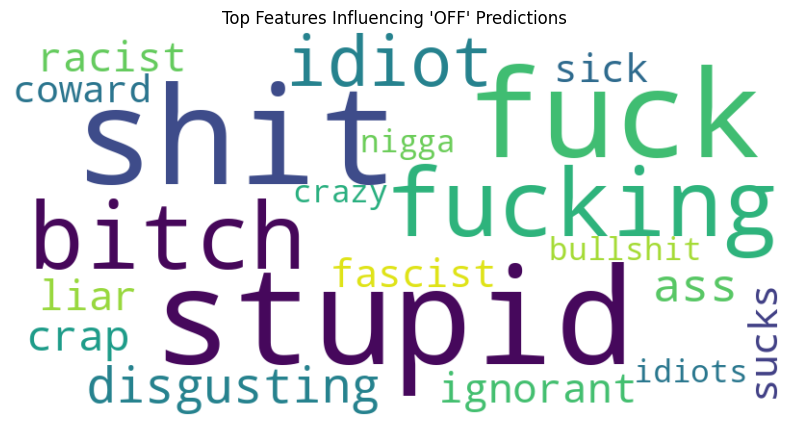

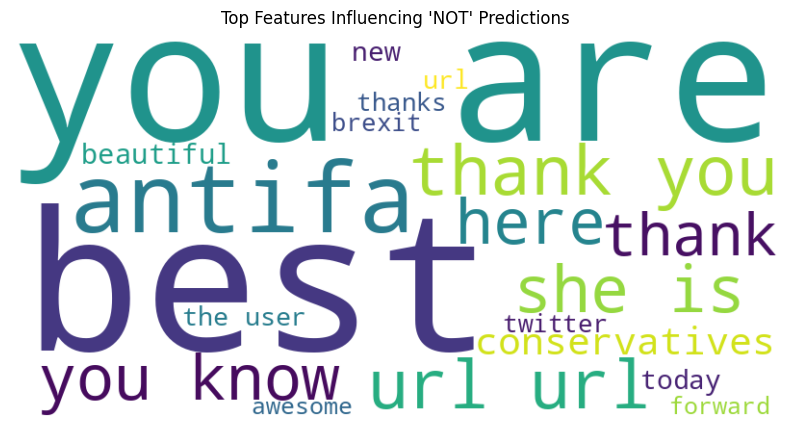

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare the top features as dictionaries for word cloud generation
# The coefficients are scaled to emphasize the importance (absolute value of coefficient)

# For "OFF" (Top positive features)
off_words = {word: abs(coef) for word, coef in top_features_off}

# For "NOT" (Top negative features)
not_words = {word: abs(coef) for word, coef in top_features_not}

# Create word clouds
def plot_wordcloud(word_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Display word clouds
plot_wordcloud(off_words, "Top Features Influencing 'OFF' Predictions")
plot_wordcloud(not_words, "Top Features Influencing 'NOT' Predictions")


* MLP Classifier

In [20]:
from gensim.models import Word2Vec

In [21]:
# Extract texts and labels
X_train_texts = train_df['text'].tolist()
y_train_labels = train_df['label'].tolist()

X_dev_texts = dev_df['text'].tolist()
y_dev_labels = dev_df['label'].tolist()
# Check the contents of X_train_texts
print(X_train_texts[:5])  # Display the first 5 elements to ensure data is loaded
print(train_df.columns)


['@USER @USER You are an embarrassing citizen!!', "@USER Seems hard to believe that you stood next to a guy wearing those shorts and didn't masturbate but I'll take your word for it", '@USER @USER @USER Wow !!! no wonder the Liberals only got worse as a party of bullies to women...??? no accountability.', '@USER @USER And not all idiots grandstands like he did', '@USER Bring on the hypocrite gungrabber. MAGA']
Index(['text', 'label', 'category'], dtype='object')


In [22]:
# Extract texts and labels
X_train_texts = train_df['text'].tolist()
y_train_labels = train_df['label'].tolist()

X_dev_texts = dev_df['text'].tolist()
y_dev_labels = dev_df['label'].tolist()

# Preprocess texts for training the Word2Vec model
train_sentences = [text.split() for text in X_train_texts]
print(train_sentences)

# Train a Word2Vec model
w2v_model = Word2Vec(sentences=train_sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)


# Function to create sentence embeddings by averaging word vectors
def get_sentence_embedding(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Generate sentence embeddings for training and development sets
X_train_embeddings = np.array([get_sentence_embedding(text, w2v_model) for text in X_train_texts])
X_dev_embeddings = np.array([get_sentence_embedding(text, w2v_model) for text in X_dev_texts])

# Initialize and train the logistic regression model
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_embeddings, y_train_labels)

# Predict labels on the development set
y_dev_pred = clf.predict(X_dev_embeddings)

# Calculate accuracy
accuracy = accuracy_score(y_dev_labels, y_dev_pred)

# Calculate precision, recall, and F1 score for both classes (OFF and NOT)
precision, recall, f1, _ = precision_recall_fscore_support(y_dev_labels, y_dev_pred, labels=['OFF', 'NOT'])

# Calculate macro F1 score
macro_f1 = precision_recall_fscore_support(y_dev_labels, y_dev_pred, labels=['OFF', 'NOT'], average='macro')[2]

# Display performance metrics
performance_metrics = {
    "Accuracy": accuracy,
    "Precision (OFF)": precision[0],
    "Precision (NOT)": precision[1],
    "Recall (OFF)": recall[0],
    "Recall (NOT)": recall[1],
    "F1 Score (OFF)": f1[0],
    "F1 Score (NOT)": f1[1],
    "Macro F1 Score": macro_f1
}

performance_metrics

[['@USER', '@USER', 'You', 'are', 'an', 'embarrassing', 'citizen!!'], ['@USER', 'Seems', 'hard', 'to', 'believe', 'that', 'you', 'stood', 'next', 'to', 'a', 'guy', 'wearing', 'those', 'shorts', 'and', "didn't", 'masturbate', 'but', "I'll", 'take', 'your', 'word', 'for', 'it'], ['@USER', '@USER', '@USER', 'Wow', '!!!', 'no', 'wonder', 'the', 'Liberals', 'only', 'got', 'worse', 'as', 'a', 'party', 'of', 'bullies', 'to', 'women...???', 'no', 'accountability.'], ['@USER', '@USER', 'And', 'not', 'all', 'idiots', 'grandstands', 'like', 'he', 'did'], ['@USER', 'Bring', 'on', 'the', 'hypocrite', 'gungrabber.', 'MAGA'], ['@USER', 'bitch', 'call', 'me.'], ['@USER', 'The', 'only', 'thing', 'i', 'didn’t', 'agree', 'with', 'was', 'the', 'match', 'point', 'he', 'was', 'following', 'the', 'rules', 'i', 'think', 'this', 'was', 'more', 'about', 'her', 'sex', 'honestly', 'all', 'she', 'did', 'was', 'call', 'him', 'a', 'thief', 'and', 'he', 'penalized', 'her', 'shit', 'was', 'wack'], ['@USER', 'I', 'seco

{'Accuracy': 0.5226586102719033,
 'Precision (OFF)': 0.3677685950413223,
 'Precision (NOT)': 0.7107023411371237,
 'Recall (OFF)': 0.6068181818181818,
 'Recall (NOT)': 0.4807692307692308,
 'F1 Score (OFF)': 0.45797598627787306,
 'F1 Score (NOT)': 0.573549257759784,
 'Macro F1 Score': 0.5157626220188285}